In [39]:
import time
import datetime
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

# NN model definition

In [40]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            if output.dim()<3:
                output=output.unsqueeze(1)
            h_t, c_t = self.lstm(output.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs


# Optimization Class

In [41]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=12,
        n_epochs=100,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)
            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

# Auxilliary functions

In [42]:
# Build index in order to transform data into time series
def dateindex_from_weeknum(weeknum, year):
    if weeknum == 1:
        date_str = "" + str(year) + "-01-01"
        dateindex = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    else:
        date_str = "" + str(year) + "-W" + str(weeknum-1) + "-1"
        dateindex = datetime.datetime.strptime(date_str, "%Y-W%W-%w")

    return dateindex

In [43]:
def test_stationarity(ts):
    
    ### Method 1: Calculate and plot rolling statistics like the mean and standard deviation
    roll_mean = ts.rolling(window=12).mean()
    roll_std = ts.rolling(window=12).std()
     
    plt.plot(ts, color="blue", label="Original TS")
    plt.plot(roll_mean, color="red", label="Rolling Mean")
    plt.plot(roll_std, color="green", label="Rolling STD")
    plt.legend(loc="best")
    plt.show()
    
    ### Method 2: Use the Dickey-Fuller statistical test 
    print("Performing Dickey-Fuller statistical test...")
    dftest = adfuller(ts, autolag="AIC")
    
    test_results = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "#Observations used"])
    for key, alpha_lvl in dftest[4].items():
        test_results['Critical Value (%s)'%key] = alpha_lvl
    print(test_results)

In [44]:
def augment_weather_data (store_df, loc_weather_df):
    ## PREPROCESS THE ORIGINAL STORE DATA
    
    # Drop unnamed column and listino column, we won't be using those
    store_df = store_df.drop(["Unnamed: 0", "listino"], axis=1)

    # Build datetime index
    store_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in store_df[["settimana", "anno"]].values]
    store_df = store_df.set_index(["time"])
    store_df.index = pd.to_datetime(store_df.index) # make ts

    # Sort the data based on the new time index
    store_df.sort_index(inplace=True)

    # Aggregate the data to get the total sales of each week
    store_weekly_totals = store_df.groupby(pd.Grouper(freq = "W-MON")).agg({
        "vendita": np.sum,
        "settimana": np.min, 
        "anno": np.min,
    })

    # Check for NAN values and replace them if they are present
    nan_indices = store_weekly_totals[store_weekly_totals.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        store_weekly_totals.loc[nan_idx, "vendita"] = np.mean(store_weekly_totals.loc[:nan_idx,"vendita"].values)
        store_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
        store_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
        
    # Drop 2020 data (we won't be using them)
    store_weekly_totals.drop(store_weekly_totals.loc["2020"].index, inplace=True)

    # Drop the year data (we won't be using it)
    store_weekly_totals.drop("anno", axis=1, inplace=True)
    # Transform the week into sin(week#/53 * 2pi) * cos(week#/53 * 2pi)
    week_nr_values = store_weekly_totals.settimana.values
    store_weekly_totals["sin_week"] =  np.sin((week_nr_values/53) * np.pi)
    store_weekly_totals["cos_week"] = np.cos((week_nr_values/53) * np.pi)
    store_weekly_totals["sincos_week"] = np.sin((week_nr_values/53) * np.pi) * np.cos((week_nr_values/53) * np.pi)
    store_weekly_totals.drop("settimana", axis=1, inplace=True) # drop the actual week number values now

    ## PREPROCESS AND ADD WEATHER DATA
    
    # Converting the index as datetime index
    loc_weather_df = loc_weather_df.set_index(["DATA"])
    loc_weather_df.index = pd.to_datetime(loc_weather_df.index) # make ts

    # We can't really group the different weather fenomenons happening each day that column can't be used
    # Also the rain and average pressure cols are useless, they only have values of 0 or nan.
    # We won't be using those either 
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    # Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
    loc_weather_df = loc_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
    loc_weather_df = loc_weather_df.fillna(0).astype(int)
    # Drop 2020 data (we won't be using them)
    loc_weather_df.drop(loc_weather_df.loc["2020"].index, inplace=True)

    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    weekly_weather_augmented = loc_weather_df.copy(deep=True)
    
    # Match the length of the weather data with the store sales data
    concat_from = weekly_weather_augmented.shape[0] - store_weekly_totals.shape[0] 
    loc_weather_df = loc_weather_df.iloc[concat_from:, :]
    weekly_weather_augmented = weekly_weather_augmented.iloc[concat_from:, :]
    print(weekly_weather_augmented.shape, store_weekly_totals.shape)
    for s_col in store_weekly_totals.columns:
        weekly_weather_augmented[s_col] = store_weekly_totals.loc[:, s_col]
    
    return loc_weather_df, weekly_weather_augmented

In [45]:
def ts_train_test_split(df, test_length=0.2):
    # Perform train-test split
    split_index = int(df.shape[0]*test_length)
    train = df[:-split_index]
    test = df[-split_index:]    
    return train, test

In [46]:
def prepare_for_network(train, test, num_lags=54):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [-1,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    for col in tr_df.columns:
        # mean std Z standardization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std
        
    
    return tr_df, pd.concat([tr_df.iloc[-num_lags:, :], te_df])

In [47]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len=54, out_len=39):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    print(tr_df.shape, te_df.shape)
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [48]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len=54, out_len=39):
    # *Data back needs to rescaled back to normal*
 
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)

    
    return rmse, mae

In [49]:
def cols_with_most_corr(df, forecast_target_col=0, corr_threshhold=0.10):
    corr_matrix = df.corr(method="spearman")
    corrmat_row = corr_matrix.iloc[forecast_target_col, :]
    corrmat_row_vals = corrmat_row.values.tolist()
    # Get only the columns that have a correlation coefficient >= corr_threshhold or =< -corr_threshhold
    correlated_features = []
    for val in corrmat_row_vals:
        if (val > corr_threshhold or val < -corr_threshhold):
            pct_zeros_in_col = df[df.iloc[:, corrmat_row_vals.index(val)] == 0].count(axis=0)[0]/len(df.index)
            if pct_zeros_in_col < 0.5:
                correlated_features.append(corrmat_row_vals.index(val))
    return correlated_features

# Load and clean data

In [50]:
## STORE DATA

# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/BUSNA.csv"))
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/PAVIA.csv"))

# Turin data
turin_data_df = pd.read_csv("../datasets/dati_nunalie/TORINO/BEINA.csv")
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/NICHE.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TODOR.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TORIN.csv"))

# Rome data
rome_data_df = pd.read_csv("../datasets/dati_nunalie/ROMA/EURR2.csv")
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/RMNAZ.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TIBUR.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC1.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC2.csv"))

print("Milan sales data")
print(milan_data_df.head())
print("\n")
print("Turin sales data")
print(turin_data_df.head())
print("\n")
print("Rome sales data")
print(rome_data_df.head())
print("\n\n")

## EXOGENOUS DATA

# weather
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv")
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv")

Milan sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0        8313  16SF181BNE-16        1         16  2016     XS   ARESE     LSI
1        8511  VA515233NE-16        1         16  2016     XS   ARESE     LSI
2        8569  16SF181BBL-16        1         16  2016      S   ARESE     LSI
3        8807   ZR121FABI-16        2         16  2016     UN   ARESE     LSI
4        8833  16SF181BNE-16        1         16  2016      S   ARESE     LSI


Turin sales data
   Unnamed: 0  codice esterno  vendita  settimana  anno taglia negozio listino
0      652733    2201611NE-17        1         19  2017      M   BEINA     LSI
1      653618        TS4BE-17        1         19  2017      S   BEINA     LSI
2      653750        TS4BE-17        1         19  2017      M   BEINA     LSI
3      653776  30038PE17BL-17        1         20  2017     38   BEINA     LSI
4      653867       BY19RS-17        1         20  2017     UN   BEINA     LSI


Rome sales data
   U

In [51]:
# Augment single location sales data and then put everything together
milan_weather_default, milan_weather_augmented = augment_weather_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_weather_default.shape)
print("Milan + exogenous data shape:", milan_weather_augmented.shape)
turin_weather_default, turin_weather_augmented = augment_weather_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_weather_default.shape)
print("Turin + exogenous data shape:", turin_weather_augmented.shape)
rome_weather_default, rome_weather_augmented = augment_weather_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_weather_default.shape)
print("Rome + exogenous data shape:", rome_weather_augmented.shape)

(195, 10) (195, 4)
Milan data original shape: (195, 10)
Milan + exogenous data shape: (195, 14)
(199, 10) (199, 4)
Turin data original shape: (199, 10)
Turin + exogenous data shape: (199, 14)
(200, 10) (200, 4)
Rome data original shape: (200, 10)
Rome + exogenous data shape: (200, 14)


In [52]:
milan_weather_default

,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb
DATA,,,,,,,,,,
2016-04-11,20,15,25,11,57,13,7,14,0,1016
2016-04-18,15,11,20,8,62,9,8,18,7,1012
2016-04-25,15,10,21,6,53,15,9,19,6,1013
2016-05-02,10,6,15,3,58,10,10,20,4,1011
2016-05-09,18,14,23,11,66,10,8,22,9,1011
...,...,...,...,...,...,...,...,...,...,...
2019-12-02,7,4,10,5,82,11,6,14,0,1012
2019-12-09,18,14,24,12,63,19,8,18,0,1015
2019-12-16,6,3,9,4,88,11,6,12,0,1009


In [53]:
milan_weather_augmented

,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,vendita,sin_week,cos_week,sincos_week
DATA,,,,,,,,,,,,,,
2016-04-11,20,15,25,11,57,13,7,14,0,1016,11.0,8.124869e-01,0.582979,4.736632e-01
2016-04-18,15,11,20,8,62,9,8,18,7,1012,25.0,8.455960e-01,0.533823,4.513989e-01
2016-04-25,15,10,21,6,53,15,9,19,6,1013,37.0,8.757349e-01,0.482792,4.227980e-01
2016-05-02,10,6,15,3,58,10,10,20,4,1011,30.0,9.027978e-01,0.430065,3.882619e-01
2016-05-09,18,14,23,11,66,10,8,22,9,1011,43.0,9.266896e-01,0.375828,3.482755e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,7,4,10,5,82,11,6,14,0,1012,1428.0,2.348860e-01,-0.972023,-2.283146e-01
2019-12-09,18,14,24,12,63,19,8,18,0,1015,198.0,1.768903e-01,-0.984231,-1.741008e-01
2019-12-16,6,3,9,4,88,11,6,12,0,1009,100.0,1.182732e-01,-0.992981,-1.174430e-01


In [59]:
## Create dicts for different datasets
def_datasets = {
    "Milan": milan_weather_default,
    "Turin": turin_weather_default,
    "Rome": rome_weather_default
}
aug_datasets = {
    "Milan": milan_weather_augmented,
    "Turin": turin_weather_augmented, 
    "Rome": rome_weather_augmented
}

# Data Visualization and Exploration 

Milan data 



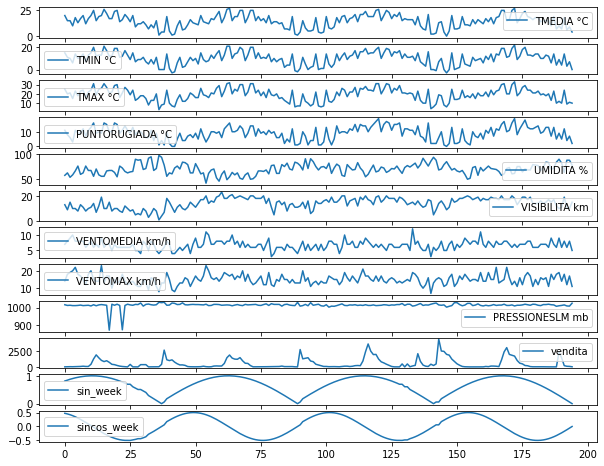

In [55]:
# Plot the data to explore and see what we are working with
for dataset in aug_datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = aug_datasets[dataset].values
    cols_to_plot = cols_with_most_corr(aug_datasets[dataset])

    
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=aug_datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

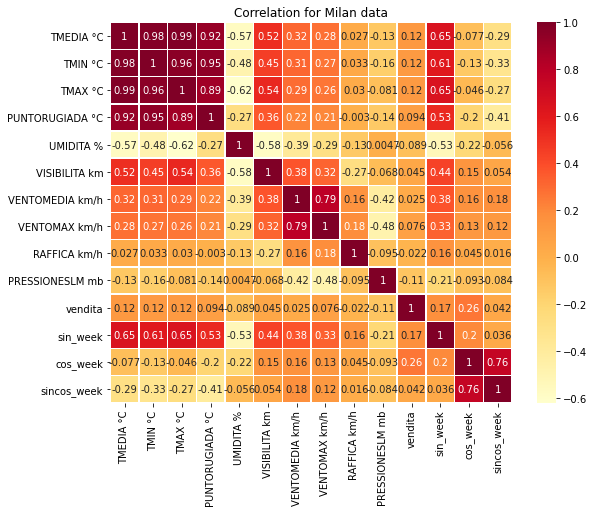

In [56]:
## Correlation matrix: Spearman Correlation
for dataset in aug_datasets:
    # Default data
    default_s_corr = aug_datasets[dataset].corr(method="spearman")
    plt.figure(figsize=(9,7))
    sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.5)
    plt.title("Correlation for "+ dataset+" data")
    plt.show()

# Forecasting evaluation

In [60]:
single_run_results = []
n_runs = 5

for dataset in aug_datasets:
    print("Running forecasting for sales in", dataset)
    curr_def_rmse = curr_def_mae = curr_aug_rmse = curr_aug_mae = 0
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        aug_dataset = aug_datasets[dataset]
        def_dataset = def_datasets[dataset]

        # Create training and test data
        def_train, def_test = ts_train_test_split(def_dataset)
        aug_train, aug_test = ts_train_test_split(aug_dataset)

        def_tr_df, def_te_df = prepare_for_network(def_train, def_test)
        aug_tr_df, aug_te_df = prepare_for_network(aug_train, aug_test)
       
        # Extract the columns which display most correlation with the value we are trying to predict.
        # As it can be seen in the 
        default_desired_input_features = cols_with_most_corr(def_dataset)
        aug_desired_input_features = cols_with_most_corr(def_dataset)
        aug_desired_input_features.append(10)
        
        print("Default input features:", default_desired_input_features)
        print("Input features with exogenous data:", aug_desired_input_features)

        # Prepare data for the LSTM Network. We need to create sequences of inputs and outputs
        # so that our time series problem esentially becomes a "supervised regression problem"
        def_inp_tr, def_out_tr, def_inp_te, def_out_te = build_in_out_seq(def_tr_df, def_te_df, default_desired_input_features)
        aug_inp_tr, aug_out_tr, aug_inp_te, aug_out_te = build_in_out_seq(aug_tr_df, aug_te_df, aug_desired_input_features)

        # Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
        def_x_train=torch.cat((torch.Tensor(def_inp_tr),torch.Tensor(def_out_tr)),1)
        def_x_test=torch.Tensor(def_inp_te)
        aug_x_train=torch.cat((torch.Tensor(aug_inp_tr),torch.Tensor(aug_out_tr)),1)
        aug_x_test=torch.Tensor(aug_inp_te)

        # Define the two LSTM Models and Optimizer objects (one for the default data and the other for the augmented)
        # First create the LSTM Model that will be used for forecasting
        loss_fn = nn.MSELoss()

        def_LSTM_Model = Model(input_size=len(default_desired_input_features), hidden_size=len(default_desired_input_features)*21, output_size=len(default_desired_input_features))
        def_optimizer = optim.Adam(def_LSTM_Model.parameters(), lr=1e-3)
        def_scheduler = optim.lr_scheduler.StepLR(optimizer=def_optimizer, step_size=25, gamma=0.1)
        def_opt_obj = Optimization(def_LSTM_Model, loss_fn, def_optimizer, def_scheduler)

        aug_LSTM_Model = Model(input_size=len(aug_desired_input_features), hidden_size=len(aug_desired_input_features)*21, output_size=len(aug_desired_input_features))
        aug_optimizer = optim.Adam(aug_LSTM_Model.parameters(), lr=1e-3)
        aug_scheduler = optim.lr_scheduler.StepLR(optimizer=aug_optimizer, step_size=25, gamma=0.1)
        aug_opt_obj = Optimization(aug_LSTM_Model, loss_fn, aug_optimizer, aug_scheduler)
        
        ## Run Drift + seasonality forecast as baseline
        print("Running Drift and Seasonal Drift models based on STL Decomposition...")
        f_steps = def_test.shape[0]
        decomp = decompose(def_train["TMEDIA °C"], period=52)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
        drift_rmse = sm.tools.eval_measures.rmse(def_test["TMEDIA °C"].values, drift_forecast["drift+seasonal"].values)
        drift_mae = sm.tools.eval_measures.meanabs(def_test["TMEDIA °C"].values, drift_forecast["drift+seasonal"].values)
        print("Done\n")
        
        # Run ARIMA as another baseline
        print("Running SARIMA model...")
        # Fit your model
        sarima_model = pm.auto_arima(def_train["TMEDIA °C"], seasonal=True, m=52, suppress_warnings=True, max_order=None, \
                                    start_p=3, start_q=0, start_P=0, start_Q=0, \
                                    max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        # Get model params
        sarima_order = sarima_model.get_params()["order"]
        sarima_s_order = sarima_model.get_params()["seasonal_order"]
        # Predict #test steps into the future
        sarima_forecasts = sarima_model.predict(f_steps)  
        sarima_rmse = sm.tools.eval_measures.rmse(def_test["TMEDIA °C"].values, sarima_forecasts)
        sarima_mae = sm.tools.eval_measures.meanabs(def_test["TMEDIA °C"].values, sarima_forecasts)
        print("Done\n")
        
        print("Running SARIMAX model...")
        sarimax_model = SARIMAX(endog=aug_train["TMEDIA °C"], exog=aug_train.iloc[:, [10]], \
                                order=sarima_order, seasonal_order=sarima_s_order)
        sarimax_fitted = sarimax_model.fit()
        sarimax_forecasts = sarimax_fitted.forecast(f_steps, exog=aug_test.iloc[:, [10]])  
        sarimax_rmse = sm.tools.eval_measures.rmse(def_test["TMEDIA °C"].values, sarimax_forecasts)
        sarimax_mae = sm.tools.eval_measures.meanabs(def_test["TMEDIA °C"].values, sarimax_forecasts)
        print("Done\n")

        # Run LSTM and Exo-LSTM
        print("Training the default LSTM model...")
        def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=len(default_desired_input_features)*10)
        print("Done\n")
        print("Training the augmented Exo-LSTM model...")
        aug_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=len(aug_desired_input_features)*10)
        print("Done\n")

        def_pred=def_LSTM_Model(def_x_test, f_steps)
        aug_pred=aug_LSTM_Model(aug_x_test, f_steps)

        # Check results of both forecasts
        def_mean = np.mean(def_train["TMEDIA °C"].values)
        def_std = np.std(def_train["TMEDIA °C"].values)
        aug_mean = np.mean(aug_train["TMEDIA °C"].values)
        aug_std = np.std(aug_train["TMEDIA °C"].values)
        
        curr_def_rmse, curr_def_mae = check_lstm_forecast_results(def_pred, def_inp_te, def_out_te, def_mean, def_std)
        curr_aug_rmse, curr_aug_mae = check_lstm_forecast_results(aug_pred, aug_inp_te, aug_out_te, aug_mean, aug_std)
        
        fig = go.Figure()
        
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=def_out_te[0,:,0]*def_std+def_mean,
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                    mode='lines', name='Drift'))
        fig.add_trace(go.Scatter(x=x_labels, y=sarima_forecasts,
                    mode='lines', name='SARIMA'+str(sarima_order)+str(sarima_s_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=sarimax_forecasts,
                    mode='lines', name='SARIMAX'+str(sarima_order)+str(sarima_s_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=def_pred[0,:,0].detach().cpu().numpy()*def_std+def_mean,
                    mode='lines', name='LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=aug_pred[0,:,0].detach().cpu().numpy()*aug_std+aug_mean,
                    mode='lines', name='Exo-LSTM'))
        # Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
        fig.show()
        pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"-weather-results.html")
        print("Scaled MAE for LSTM:", MASE((def_inp_te[0,:,0] * def_std) + def_mean, (def_out_te[0,:,0] * def_std) + def_mean, (def_pred[0,-39:,0].detach().cpu().numpy()*def_std)+def_mean))
        print("Scaled MAE for Exo-LSTM:", MASE((aug_inp_te[0,:,0] * aug_std) + aug_mean, (aug_out_te[0,:,0] * aug_std) + aug_mean, (aug_pred[0,-39:,0].detach().cpu().numpy()*aug_std)+aug_mean))
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, sarima_rmse, sarimax_rmse, curr_def_rmse, curr_aug_rmse, \
                                   drift_mae, sarima_mae, sarimax_mae, curr_def_mae, curr_aug_mae])
        print()

Running forecasting for sales in Milan
Run # 1
Default input features: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
(156, 10) (93, 10)
Inputs for training
(64, 54, 9)
Outputs for training
(64, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


(156, 14) (93, 14)
Inputs for training
(64, 54, 10)
Outputs for training
(64, 39, 10)
Inputs for testing
(1, 54, 10)
Outputs for testing
(1, 39, 10)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelF

Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.15. Validation loss: 1.08. Avg future: 20.00. Elapsed time: 1.36s.
Epoch 2 Train loss: 1.03. Validation loss: 0.93. Avg future: 25.20. Elapsed time: 0.82s.
Epoch 3 Train loss: 0.92. Validation loss: 0.85. Avg future: 36.60. Elapsed time: 0.70s.
Epoch 4 Train loss: 0.83. Validation loss: 0.81. Avg future: 14.60. Elapsed time: 0.76s.
Epoch 5 Train loss: 0.80. Validation loss: 0.80. Avg future: 15.40. Elapsed time: 0.79s.
Epoch 6 Train loss: 0.79. Validation loss: 0.79. Avg future: 25.80. Elapsed time: 0.70s.
Epoch 7 Train loss: 0.77. Validation loss: 0.78. Avg future: 24.40. Elapsed time: 0.70s.
Epoch 8 Train loss: 0.76. Validation loss: 0.76. Avg future: 11.40. Elapsed time: 0.72s.
Epoch 9 Train loss: 0.75. Validation loss: 0.75. Avg future: 22.20. Elapsed time: 0.69s.
Epoch 10 Train loss: 0.74. Validation loss: 0.74. Avg future: 20.60. Elapsed time: 0.76s.
Epoch 11 Train loss: 0.72. Validation loss: 0.73. Avg future: 23.20.

Epoch 2 Train loss: 1.03. Validation loss: 0.93. Avg future: 19.20. Elapsed time: 0.71s.
Epoch 3 Train loss: 0.91. Validation loss: 0.85. Avg future: 31.80. Elapsed time: 0.68s.
Epoch 4 Train loss: 0.83. Validation loss: 0.81. Avg future: 20.00. Elapsed time: 0.83s.
Epoch 5 Train loss: 0.79. Validation loss: 0.81. Avg future: 28.40. Elapsed time: 0.69s.
Epoch 6 Train loss: 0.78. Validation loss: 0.78. Avg future: 33.20. Elapsed time: 0.72s.
Epoch 7 Train loss: 0.76. Validation loss: 0.76. Avg future: 19.00. Elapsed time: 0.74s.
Epoch 8 Train loss: 0.73. Validation loss: 0.74. Avg future: 38.80. Elapsed time: 0.73s.
Epoch 9 Train loss: 0.71. Validation loss: 0.72. Avg future: 28.80. Elapsed time: 0.74s.
Epoch 10 Train loss: 0.69. Validation loss: 0.70. Avg future: 26.40. Elapsed time: 0.70s.
Epoch 11 Train loss: 0.68. Validation loss: 0.69. Avg future: 27.00. Elapsed time: 0.70s.
Epoch 12 Train loss: 0.67. Validation loss: 0.68. Avg future: 28.40. Elapsed time: 0.71s.
Epoch 13 Train los

Epoch 94 Train loss: 0.49. Validation loss: 0.49. Avg future: 17.00. Elapsed time: 0.67s.
Epoch 95 Train loss: 0.49. Validation loss: 0.49. Avg future: 9.00. Elapsed time: 0.68s.
Epoch 96 Train loss: 0.49. Validation loss: 0.49. Avg future: 18.20. Elapsed time: 0.69s.
Epoch 97 Train loss: 0.49. Validation loss: 0.49. Avg future: 22.80. Elapsed time: 0.69s.
Epoch 98 Train loss: 0.49. Validation loss: 0.49. Avg future: 32.80. Elapsed time: 0.71s.
Epoch 99 Train loss: 0.49. Validation loss: 0.49. Avg future: 19.20. Elapsed time: 0.87s.
Epoch 100 Train loss: 0.48. Validation loss: 0.49. Avg future: 16.80. Elapsed time: 0.79s.
Done



Scaled MAE for LSTM: 0.26324003766667764
Scaled MAE for Exo-LSTM: 0.23226453203958974

Run # 2
Default input features: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
(156, 10) (93, 10)
Inputs for training
(64, 54, 9)
Outputs for training
(64, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


(156, 14) (93, 14)
Inputs for training
(64, 54, 10)
Outputs for training
(64, 39, 10)
Inputs for testing
(1, 54, 10)
Outputs for testing
(1, 39, 10)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelF

Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.16. Validation loss: 1.09. Avg future: 15.80. Elapsed time: 0.95s.
Epoch 2 Train loss: 1.04. Validation loss: 0.94. Avg future: 14.80. Elapsed time: 1.17s.
Epoch 3 Train loss: 0.91. Validation loss: 0.85. Avg future: 33.60. Elapsed time: 1.57s.
Epoch 4 Train loss: 0.83. Validation loss: 0.82. Avg future: 30.20. Elapsed time: 0.73s.
Epoch 5 Train loss: 0.80. Validation loss: 0.81. Avg future: 33.40. Elapsed time: 0.82s.
Epoch 6 Train loss: 0.79. Validation loss: 0.79. Avg future: 20.40. Elapsed time: 0.71s.
Epoch 7 Train loss: 0.77. Validation loss: 0.77. Avg future: 11.60. Elapsed time: 0.82s.
Epoch 8 Train loss: 0.76. Validation loss: 0.76. Avg future: 20.00. Elapsed time: 0.92s.
Epoch 9 Train loss: 0.74. Validation loss: 0.75. Avg future: 20.20. Elapsed time: 0.97s.
Epoch 10 Train loss: 0.73. Validation loss: 0.74. Avg future: 16.80. Elapsed time: 0.96s.
Epoch 11 Train loss: 0.72. Validation loss: 0.73. Avg future: 22.20.

Epoch 2 Train loss: 1.02. Validation loss: 0.93. Avg future: 18.00. Elapsed time: 0.78s.
Epoch 3 Train loss: 0.90. Validation loss: 0.84. Avg future: 27.60. Elapsed time: 0.78s.
Epoch 4 Train loss: 0.82. Validation loss: 0.81. Avg future: 31.20. Elapsed time: 0.91s.
Epoch 5 Train loss: 0.80. Validation loss: 0.80. Avg future: 19.60. Elapsed time: 0.83s.
Epoch 6 Train loss: 0.78. Validation loss: 0.78. Avg future: 28.60. Elapsed time: 0.87s.
Epoch 7 Train loss: 0.76. Validation loss: 0.76. Avg future: 25.60. Elapsed time: 0.78s.
Epoch 8 Train loss: 0.73. Validation loss: 0.73. Avg future: 25.20. Elapsed time: 0.79s.
Epoch 9 Train loss: 0.71. Validation loss: 0.71. Avg future: 30.80. Elapsed time: 0.75s.
Epoch 10 Train loss: 0.69. Validation loss: 0.70. Avg future: 32.40. Elapsed time: 0.83s.
Epoch 11 Train loss: 0.68. Validation loss: 0.68. Avg future: 24.80. Elapsed time: 0.77s.
Epoch 12 Train loss: 0.67. Validation loss: 0.67. Avg future: 27.40. Elapsed time: 0.78s.
Epoch 13 Train los

Epoch 94 Train loss: 0.50. Validation loss: 0.49. Avg future: 23.20. Elapsed time: 1.96s.
Epoch 95 Train loss: 0.50. Validation loss: 0.49. Avg future: 26.00. Elapsed time: 3.39s.
Epoch 96 Train loss: 0.50. Validation loss: 0.49. Avg future: 19.60. Elapsed time: 1.36s.
Epoch 97 Train loss: 0.50. Validation loss: 0.49. Avg future: 17.60. Elapsed time: 0.80s.
Epoch 98 Train loss: 0.50. Validation loss: 0.49. Avg future: 26.00. Elapsed time: 1.37s.
Epoch 99 Train loss: 0.50. Validation loss: 0.49. Avg future: 23.00. Elapsed time: 0.88s.
Epoch 100 Train loss: 0.50. Validation loss: 0.49. Avg future: 37.60. Elapsed time: 0.77s.
Done



Scaled MAE for LSTM: 0.2583676935271371
Scaled MAE for Exo-LSTM: 0.22151206447789082

Run # 3
Default input features: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
(156, 10) (93, 10)
Inputs for training
(64, 54, 9)
Outputs for training
(64, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


(156, 14) (93, 14)
Inputs for training
(64, 54, 10)
Outputs for training
(64, 39, 10)
Inputs for testing
(1, 54, 10)
Outputs for testing
(1, 39, 10)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelF

Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.17. Validation loss: 1.09. Avg future: 26.20. Elapsed time: 0.65s.
Epoch 2 Train loss: 1.04. Validation loss: 0.95. Avg future: 26.60. Elapsed time: 0.63s.
Epoch 3 Train loss: 0.93. Validation loss: 0.86. Avg future: 11.20. Elapsed time: 0.67s.
Epoch 4 Train loss: 0.84. Validation loss: 0.83. Avg future: 17.00. Elapsed time: 0.63s.
Epoch 5 Train loss: 0.81. Validation loss: 0.81. Avg future: 25.00. Elapsed time: 0.64s.
Epoch 6 Train loss: 0.79. Validation loss: 0.79. Avg future: 19.80. Elapsed time: 0.63s.
Epoch 7 Train loss: 0.77. Validation loss: 0.78. Avg future: 23.00. Elapsed time: 0.66s.
Epoch 8 Train loss: 0.76. Validation loss: 0.76. Avg future: 22.60. Elapsed time: 0.71s.
Epoch 9 Train loss: 0.74. Validation loss: 0.75. Avg future: 29.60. Elapsed time: 0.65s.
Epoch 10 Train loss: 0.73. Validation loss: 0.74. Avg future: 31.40. Elapsed time: 0.64s.
Epoch 11 Train loss: 0.72. Validation loss: 0.73. Avg future: 13.80.

Epoch 2 Train loss: 1.02. Validation loss: 0.92. Avg future: 27.00. Elapsed time: 0.80s.
Epoch 3 Train loss: 0.90. Validation loss: 0.84. Avg future: 35.80. Elapsed time: 0.86s.
Epoch 4 Train loss: 0.83. Validation loss: 0.81. Avg future: 23.80. Elapsed time: 0.94s.
Epoch 5 Train loss: 0.80. Validation loss: 0.80. Avg future: 25.00. Elapsed time: 1.13s.
Epoch 6 Train loss: 0.78. Validation loss: 0.78. Avg future: 25.40. Elapsed time: 0.82s.
Epoch 7 Train loss: 0.76. Validation loss: 0.76. Avg future: 15.60. Elapsed time: 0.84s.
Epoch 8 Train loss: 0.74. Validation loss: 0.74. Avg future: 18.00. Elapsed time: 0.95s.
Epoch 9 Train loss: 0.72. Validation loss: 0.72. Avg future: 21.20. Elapsed time: 0.79s.
Epoch 10 Train loss: 0.70. Validation loss: 0.70. Avg future: 25.40. Elapsed time: 0.86s.
Epoch 11 Train loss: 0.69. Validation loss: 0.68. Avg future: 20.60. Elapsed time: 0.84s.
Epoch 12 Train loss: 0.67. Validation loss: 0.67. Avg future: 21.60. Elapsed time: 0.77s.
Epoch 13 Train los

Epoch 94 Train loss: 0.49. Validation loss: 0.49. Avg future: 17.40. Elapsed time: 1.11s.
Epoch 95 Train loss: 0.49. Validation loss: 0.49. Avg future: 22.00. Elapsed time: 0.93s.
Epoch 96 Train loss: 0.49. Validation loss: 0.49. Avg future: 22.40. Elapsed time: 0.72s.
Epoch 97 Train loss: 0.49. Validation loss: 0.49. Avg future: 26.00. Elapsed time: 1.19s.
Epoch 98 Train loss: 0.49. Validation loss: 0.49. Avg future: 23.60. Elapsed time: 0.85s.
Epoch 99 Train loss: 0.49. Validation loss: 0.49. Avg future: 22.20. Elapsed time: 0.81s.
Epoch 100 Train loss: 0.50. Validation loss: 0.49. Avg future: 33.20. Elapsed time: 0.89s.
Done



Scaled MAE for LSTM: 0.27394055375547816
Scaled MAE for Exo-LSTM: 0.2074701819833353

Run # 4
Default input features: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
(156, 10) (93, 10)
Inputs for training
(64, 54, 9)
Outputs for training
(64, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


(156, 14) (93, 14)
Inputs for training
(64, 54, 10)
Outputs for training
(64, 39, 10)
Inputs for testing
(1, 54, 10)
Outputs for testing
(1, 39, 10)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelF

Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.18. Validation loss: 1.11. Avg future: 21.20. Elapsed time: 0.72s.
Epoch 2 Train loss: 1.07. Validation loss: 0.98. Avg future: 21.00. Elapsed time: 0.82s.
Epoch 3 Train loss: 0.94. Validation loss: 0.88. Avg future: 19.60. Elapsed time: 0.88s.
Epoch 4 Train loss: 0.85. Validation loss: 0.83. Avg future: 20.60. Elapsed time: 0.78s.
Epoch 5 Train loss: 0.81. Validation loss: 0.80. Avg future: 16.80. Elapsed time: 0.75s.
Epoch 6 Train loss: 0.78. Validation loss: 0.79. Avg future: 29.20. Elapsed time: 0.71s.
Epoch 7 Train loss: 0.77. Validation loss: 0.78. Avg future: 23.60. Elapsed time: 0.80s.
Epoch 8 Train loss: 0.75. Validation loss: 0.76. Avg future: 26.00. Elapsed time: 0.83s.
Epoch 9 Train loss: 0.74. Validation loss: 0.75. Avg future: 24.00. Elapsed time: 0.69s.
Epoch 10 Train loss: 0.73. Validation loss: 0.74. Avg future: 31.20. Elapsed time: 0.75s.
Epoch 11 Train loss: 0.71. Validation loss: 0.72. Avg future: 28.80.

Epoch 2 Train loss: 1.03. Validation loss: 0.93. Avg future: 27.40. Elapsed time: 0.87s.
Epoch 3 Train loss: 0.91. Validation loss: 0.85. Avg future: 22.80. Elapsed time: 0.86s.
Epoch 4 Train loss: 0.84. Validation loss: 0.82. Avg future: 20.00. Elapsed time: 0.74s.
Epoch 5 Train loss: 0.80. Validation loss: 0.81. Avg future: 19.40. Elapsed time: 0.81s.
Epoch 6 Train loss: 0.78. Validation loss: 0.78. Avg future: 29.60. Elapsed time: 0.80s.
Epoch 7 Train loss: 0.76. Validation loss: 0.76. Avg future: 26.00. Elapsed time: 0.79s.
Epoch 8 Train loss: 0.74. Validation loss: 0.74. Avg future: 28.20. Elapsed time: 1.00s.
Epoch 9 Train loss: 0.71. Validation loss: 0.72. Avg future: 25.40. Elapsed time: 0.98s.
Epoch 10 Train loss: 0.69. Validation loss: 0.70. Avg future: 33.40. Elapsed time: 1.02s.
Epoch 11 Train loss: 0.68. Validation loss: 0.69. Avg future: 23.60. Elapsed time: 0.96s.
Epoch 12 Train loss: 0.67. Validation loss: 0.67. Avg future: 26.00. Elapsed time: 0.90s.
Epoch 13 Train los

Epoch 94 Train loss: 0.50. Validation loss: 0.50. Avg future: 14.60. Elapsed time: 1.20s.
Epoch 95 Train loss: 0.50. Validation loss: 0.50. Avg future: 16.60. Elapsed time: 0.91s.
Epoch 96 Train loss: 0.50. Validation loss: 0.50. Avg future: 16.80. Elapsed time: 0.88s.
Epoch 97 Train loss: 0.50. Validation loss: 0.50. Avg future: 16.40. Elapsed time: 0.76s.
Epoch 98 Train loss: 0.50. Validation loss: 0.50. Avg future: 22.60. Elapsed time: 0.90s.
Epoch 99 Train loss: 0.50. Validation loss: 0.50. Avg future: 16.60. Elapsed time: 0.69s.
Epoch 100 Train loss: 0.50. Validation loss: 0.50. Avg future: 24.20. Elapsed time: 0.68s.
Done



Scaled MAE for LSTM: 0.269034618140035
Scaled MAE for Exo-LSTM: 0.21933897774085268

Run # 5
Default input features: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
(156, 10) (93, 10)
Inputs for training
(64, 54, 9)
Outputs for training
(64, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


(156, 14) (93, 14)
Inputs for training
(64, 54, 10)
Outputs for training
(64, 39, 10)
Inputs for testing
(1, 54, 10)
Outputs for testing
(1, 39, 10)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (3, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelF

Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.16. Validation loss: 1.09. Avg future: 13.40. Elapsed time: 0.87s.
Epoch 2 Train loss: 1.04. Validation loss: 0.94. Avg future: 34.00. Elapsed time: 0.79s.
Epoch 3 Train loss: 0.90. Validation loss: 0.84. Avg future: 28.60. Elapsed time: 0.81s.
Epoch 4 Train loss: 0.82. Validation loss: 0.81. Avg future: 30.40. Elapsed time: 0.70s.
Epoch 5 Train loss: 0.80. Validation loss: 0.80. Avg future: 15.40. Elapsed time: 0.77s.
Epoch 6 Train loss: 0.79. Validation loss: 0.78. Avg future: 5.20. Elapsed time: 0.71s.
Epoch 7 Train loss: 0.76. Validation loss: 0.77. Avg future: 18.20. Elapsed time: 0.69s.
Epoch 8 Train loss: 0.76. Validation loss: 0.76. Avg future: 21.60. Elapsed time: 0.78s.
Epoch 9 Train loss: 0.74. Validation loss: 0.74. Avg future: 20.00. Elapsed time: 0.75s.
Epoch 10 Train loss: 0.72. Validation loss: 0.73. Avg future: 29.80. Elapsed time: 0.64s.
Epoch 11 Train loss: 0.72. Validation loss: 0.72. Avg future: 15.00. 

Epoch 2 Train loss: 1.02. Validation loss: 0.93. Avg future: 11.20. Elapsed time: 0.78s.
Epoch 3 Train loss: 0.91. Validation loss: 0.85. Avg future: 16.00. Elapsed time: 0.87s.
Epoch 4 Train loss: 0.85. Validation loss: 0.82. Avg future: 34.20. Elapsed time: 0.71s.
Epoch 5 Train loss: 0.80. Validation loss: 0.81. Avg future: 25.20. Elapsed time: 0.81s.
Epoch 6 Train loss: 0.79. Validation loss: 0.79. Avg future: 27.60. Elapsed time: 0.75s.
Epoch 7 Train loss: 0.77. Validation loss: 0.77. Avg future: 25.80. Elapsed time: 0.84s.
Epoch 8 Train loss: 0.74. Validation loss: 0.75. Avg future: 29.00. Elapsed time: 0.83s.
Epoch 9 Train loss: 0.73. Validation loss: 0.73. Avg future: 15.20. Elapsed time: 0.87s.
Epoch 10 Train loss: 0.71. Validation loss: 0.71. Avg future: 31.20. Elapsed time: 0.75s.
Epoch 11 Train loss: 0.70. Validation loss: 0.70. Avg future: 17.20. Elapsed time: 0.81s.
Epoch 12 Train loss: 0.68. Validation loss: 0.69. Avg future: 23.40. Elapsed time: 0.86s.
Epoch 13 Train los

Epoch 94 Train loss: 0.52. Validation loss: 0.52. Avg future: 19.40. Elapsed time: 0.91s.
Epoch 95 Train loss: 0.52. Validation loss: 0.52. Avg future: 15.40. Elapsed time: 0.67s.
Epoch 96 Train loss: 0.52. Validation loss: 0.52. Avg future: 20.20. Elapsed time: 0.82s.
Epoch 97 Train loss: 0.52. Validation loss: 0.52. Avg future: 24.40. Elapsed time: 0.71s.
Epoch 98 Train loss: 0.52. Validation loss: 0.52. Avg future: 17.80. Elapsed time: 0.79s.
Epoch 99 Train loss: 0.52. Validation loss: 0.52. Avg future: 13.00. Elapsed time: 0.78s.
Epoch 100 Train loss: 0.52. Validation loss: 0.52. Avg future: 17.80. Elapsed time: 0.80s.
Done



Scaled MAE for LSTM: 0.222478163563365
Scaled MAE for Exo-LSTM: 0.20191914072787545

Running forecasting for sales in Turin
Run # 1
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (93, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(1, 54, 8)
Outputs for testing
(1, 39, 8)


(160, 14) (93, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.19. Validation loss: 1.13. Avg future: 8.40. Elapsed time: 0.69s.
Epoch 2 Train loss: 1.09. Validation loss: 1.01. Avg future: 26.00. Elapsed time: 0.64s.
Epoch 3 Train loss: 0.99. Validation loss: 0.94. Avg future: 25.80. Elapsed time: 0.71s.
Epoch 4 Train loss: 0.92. Validation loss: 0.90. Avg future: 34.20. Elapsed time: 0.64s.
Epoch 5 Train loss: 0.88. Validation loss: 0.87. Avg future: 26.80. Elapsed time: 0.64s.
Epoch 6 Train loss: 0.85. Validation loss: 0.87. Avg future: 28.40. Elapsed time: 0.62s.
Epoch 7 Train loss: 0.86. Validation loss: 0.85. Avg future: 19.20. Elapsed time: 0.66s.
Epoch 8 Train loss: 0.84. Validation loss: 0.84. Avg future: 11.40. Elapsed time: 0.67s.
Epoch 9 Train loss: 0.81. Validation loss: 0.82. Avg future: 24.20. Elapsed time: 0.68s.
Epoch 10 Train loss: 0.81. Validation loss: 0.81. Avg future: 16.60. Elapsed time: 0.67s.
Epoch 11 Train loss: 0.80. Validation loss: 0.80. Avg future: 13.60. 

Epoch 12 Train loss: 0.72. Validation loss: 0.71. Avg future: 20.00. Elapsed time: 0.64s.
Epoch 13 Train loss: 0.70. Validation loss: 0.70. Avg future: 18.60. Elapsed time: 0.63s.
Epoch 14 Train loss: 0.69. Validation loss: 0.69. Avg future: 18.00. Elapsed time: 0.64s.
Epoch 15 Train loss: 0.67. Validation loss: 0.68. Avg future: 28.40. Elapsed time: 0.64s.
Epoch 16 Train loss: 0.67. Validation loss: 0.66. Avg future: 18.40. Elapsed time: 0.64s.
Epoch 17 Train loss: 0.66. Validation loss: 0.65. Avg future: 22.60. Elapsed time: 0.64s.
Epoch 18 Train loss: 0.65. Validation loss: 0.65. Avg future: 23.20. Elapsed time: 0.62s.
Epoch 19 Train loss: 0.65. Validation loss: 0.64. Avg future: 25.80. Elapsed time: 0.64s.
Epoch 20 Train loss: 0.64. Validation loss: 0.63. Avg future: 21.60. Elapsed time: 0.64s.
Epoch 21 Train loss: 0.62. Validation loss: 0.62. Avg future: 20.80. Elapsed time: 0.64s.
Epoch 22 Train loss: 0.61. Validation loss: 0.61. Avg future: 24.40. Elapsed time: 0.64s.
Epoch 23 T

Scaled MAE for LSTM: 0.21388604830968572
Scaled MAE for Exo-LSTM: 0.2173385464475953

Run # 2
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (93, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(1, 54, 8)
Outputs for testing
(1, 39, 8)


(160, 14) (93, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.19. Validation loss: 1.12. Avg future: 18.40. Elapsed time: 0.71s.
Epoch 2 Train loss: 1.09. Validation loss: 1.01. Avg future: 26.60. Elapsed time: 0.57s.
Epoch 3 Train loss: 0.98. Validation loss: 0.93. Avg future: 29.20. Elapsed time: 0.59s.
Epoch 4 Train loss: 0.92. Validation loss: 0.89. Avg future: 26.60. Elapsed time: 0.68s.
Epoch 5 Train loss: 0.87. Validation loss: 0.87. Avg future: 32.60. Elapsed time: 0.78s.
Epoch 6 Train loss: 0.85. Validation loss: 0.86. Avg future: 23.60. Elapsed time: 0.57s.
Epoch 7 Train loss: 0.84. Validation loss: 0.85. Avg future: 30.80. Elapsed time: 0.75s.
Epoch 8 Train loss: 0.83. Validation loss: 0.83. Avg future: 16.80. Elapsed time: 0.86s.
Epoch 9 Train loss: 0.80. Validation loss: 0.81. Avg future: 28.60. Elapsed time: 0.74s.
Epoch 10 Train loss: 0.80. Validation loss: 0.80. Avg future: 24.60. Elapsed time: 0.66s.
Epoch 11 Train loss: 0.78. Validation loss: 0.78. Avg future: 21.40.

Epoch 12 Train loss: 0.72. Validation loss: 0.71. Avg future: 15.80. Elapsed time: 0.92s.
Epoch 13 Train loss: 0.70. Validation loss: 0.70. Avg future: 16.00. Elapsed time: 1.59s.
Epoch 14 Train loss: 0.68. Validation loss: 0.69. Avg future: 26.20. Elapsed time: 0.76s.
Epoch 15 Train loss: 0.68. Validation loss: 0.68. Avg future: 34.20. Elapsed time: 0.90s.
Epoch 16 Train loss: 0.67. Validation loss: 0.67. Avg future: 22.40. Elapsed time: 1.08s.
Epoch 17 Train loss: 0.66. Validation loss: 0.65. Avg future: 20.20. Elapsed time: 0.64s.
Epoch 18 Train loss: 0.65. Validation loss: 0.64. Avg future: 20.00. Elapsed time: 1.15s.
Epoch 19 Train loss: 0.64. Validation loss: 0.64. Avg future: 27.60. Elapsed time: 0.72s.
Epoch 20 Train loss: 0.63. Validation loss: 0.63. Avg future: 32.20. Elapsed time: 1.09s.
Epoch 21 Train loss: 0.62. Validation loss: 0.62. Avg future: 19.80. Elapsed time: 0.99s.
Epoch 22 Train loss: 0.61. Validation loss: 0.60. Avg future: 15.80. Elapsed time: 0.98s.
Epoch 23 T

Scaled MAE for LSTM: 0.24456386926350954
Scaled MAE for Exo-LSTM: 0.21472800614019277

Run # 3
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (93, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(1, 54, 8)
Outputs for testing
(1, 39, 8)


(160, 14) (93, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.20. Validation loss: 1.14. Avg future: 21.60. Elapsed time: 0.69s.
Epoch 2 Train loss: 1.09. Validation loss: 1.02. Avg future: 15.20. Elapsed time: 0.67s.
Epoch 3 Train loss: 0.99. Validation loss: 0.93. Avg future: 19.60. Elapsed time: 0.65s.
Epoch 4 Train loss: 0.94. Validation loss: 0.90. Avg future: 28.60. Elapsed time: 1.04s.
Epoch 5 Train loss: 0.87. Validation loss: 0.88. Avg future: 35.80. Elapsed time: 1.30s.
Epoch 6 Train loss: 0.85. Validation loss: 0.87. Avg future: 35.00. Elapsed time: 0.65s.
Epoch 7 Train loss: 0.85. Validation loss: 0.85. Avg future: 23.80. Elapsed time: 0.62s.
Epoch 8 Train loss: 0.84. Validation loss: 0.84. Avg future: 16.80. Elapsed time: 0.64s.
Epoch 9 Train loss: 0.82. Validation loss: 0.82. Avg future: 24.80. Elapsed time: 0.63s.
Epoch 10 Train loss: 0.80. Validation loss: 0.81. Avg future: 34.00. Elapsed time: 0.60s.
Epoch 11 Train loss: 0.79. Validation loss: 0.80. Avg future: 28.00.

Epoch 12 Train loss: 0.74. Validation loss: 0.73. Avg future: 12.00. Elapsed time: 0.66s.
Epoch 13 Train loss: 0.72. Validation loss: 0.72. Avg future: 31.80. Elapsed time: 0.75s.
Epoch 14 Train loss: 0.70. Validation loss: 0.70. Avg future: 22.80. Elapsed time: 0.69s.
Epoch 15 Train loss: 0.69. Validation loss: 0.68. Avg future: 16.00. Elapsed time: 0.69s.
Epoch 16 Train loss: 0.67. Validation loss: 0.67. Avg future: 28.20. Elapsed time: 0.72s.
Epoch 17 Train loss: 0.67. Validation loss: 0.66. Avg future: 18.20. Elapsed time: 0.81s.
Epoch 18 Train loss: 0.65. Validation loss: 0.65. Avg future: 25.40. Elapsed time: 0.75s.
Epoch 19 Train loss: 0.64. Validation loss: 0.64. Avg future: 28.40. Elapsed time: 0.79s.
Epoch 20 Train loss: 0.64. Validation loss: 0.63. Avg future: 29.60. Elapsed time: 0.68s.
Epoch 21 Train loss: 0.63. Validation loss: 0.63. Avg future: 19.80. Elapsed time: 0.72s.
Epoch 22 Train loss: 0.62. Validation loss: 0.61. Avg future: 16.20. Elapsed time: 0.82s.
Epoch 23 T

Scaled MAE for LSTM: 0.22813730466225374
Scaled MAE for Exo-LSTM: 0.2293759773939084

Run # 4
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (93, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(1, 54, 8)
Outputs for testing
(1, 39, 8)


(160, 14) (93, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.20. Validation loss: 1.14. Avg future: 26.20. Elapsed time: 0.58s.
Epoch 2 Train loss: 1.11. Validation loss: 1.03. Avg future: 27.40. Elapsed time: 0.55s.
Epoch 3 Train loss: 1.00. Validation loss: 0.94. Avg future: 17.00. Elapsed time: 0.54s.
Epoch 4 Train loss: 0.94. Validation loss: 0.90. Avg future: 29.20. Elapsed time: 0.54s.
Epoch 5 Train loss: 0.88. Validation loss: 0.87. Avg future: 17.80. Elapsed time: 0.54s.
Epoch 6 Train loss: 0.85. Validation loss: 0.86. Avg future: 34.40. Elapsed time: 0.54s.
Epoch 7 Train loss: 0.84. Validation loss: 0.85. Avg future: 25.00. Elapsed time: 0.56s.
Epoch 8 Train loss: 0.82. Validation loss: 0.83. Avg future: 25.20. Elapsed time: 0.59s.
Epoch 9 Train loss: 0.81. Validation loss: 0.82. Avg future: 25.20. Elapsed time: 0.99s.
Epoch 10 Train loss: 0.80. Validation loss: 0.80. Avg future: 15.80. Elapsed time: 0.67s.
Epoch 11 Train loss: 0.79. Validation loss: 0.79. Avg future: 17.60.

Epoch 12 Train loss: 0.71. Validation loss: 0.71. Avg future: 21.00. Elapsed time: 0.69s.
Epoch 13 Train loss: 0.71. Validation loss: 0.71. Avg future: 24.40. Elapsed time: 0.74s.
Epoch 14 Train loss: 0.70. Validation loss: 0.69. Avg future: 19.40. Elapsed time: 0.66s.
Epoch 15 Train loss: 0.69. Validation loss: 0.70. Avg future: 17.00. Elapsed time: 0.63s.
Epoch 16 Train loss: 0.68. Validation loss: 0.67. Avg future: 19.40. Elapsed time: 0.65s.
Epoch 17 Train loss: 0.67. Validation loss: 0.66. Avg future: 21.00. Elapsed time: 0.65s.
Epoch 18 Train loss: 0.66. Validation loss: 0.65. Avg future: 29.40. Elapsed time: 0.62s.
Epoch 19 Train loss: 0.64. Validation loss: 0.64. Avg future: 24.60. Elapsed time: 0.66s.
Epoch 20 Train loss: 0.63. Validation loss: 0.63. Avg future: 16.60. Elapsed time: 0.66s.
Epoch 21 Train loss: 0.62. Validation loss: 0.62. Avg future: 24.00. Elapsed time: 0.67s.
Epoch 22 Train loss: 0.62. Validation loss: 0.61. Avg future: 20.20. Elapsed time: 0.63s.
Epoch 23 T

Scaled MAE for LSTM: 0.28227243010401315
Scaled MAE for Exo-LSTM: 0.21533966928575904

Run # 5
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (93, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(1, 54, 8)
Outputs for testing
(1, 39, 8)


(160, 14) (93, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(1, 54, 9)
Outputs for testing
(1, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.19. Validation loss: 1.14. Avg future: 13.80. Elapsed time: 0.73s.
Epoch 2 Train loss: 1.11. Validation loss: 1.02. Avg future: 28.80. Elapsed time: 0.98s.
Epoch 3 Train loss: 0.99. Validation loss: 0.94. Avg future: 20.20. Elapsed time: 0.64s.
Epoch 4 Train loss: 0.92. Validation loss: 0.89. Avg future: 33.40. Elapsed time: 0.57s.
Epoch 5 Train loss: 0.87. Validation loss: 0.87. Avg future: 26.00. Elapsed time: 0.65s.
Epoch 6 Train loss: 0.85. Validation loss: 0.86. Avg future: 19.20. Elapsed time: 0.62s.
Epoch 7 Train loss: 0.83. Validation loss: 0.84. Avg future: 25.80. Elapsed time: 0.62s.
Epoch 8 Train loss: 0.82. Validation loss: 0.83. Avg future: 24.60. Elapsed time: 0.64s.
Epoch 9 Train loss: 0.79. Validation loss: 0.81. Avg future: 38.00. Elapsed time: 0.59s.
Epoch 10 Train loss: 0.79. Validation loss: 0.80. Avg future: 22.40. Elapsed time: 0.73s.
Epoch 11 Train loss: 0.78. Validation loss: 0.78. Avg future: 24.20.

Epoch 12 Train loss: 0.71. Validation loss: 0.70. Avg future: 17.60. Elapsed time: 0.86s.
Epoch 13 Train loss: 0.69. Validation loss: 0.69. Avg future: 29.40. Elapsed time: 0.75s.
Epoch 14 Train loss: 0.69. Validation loss: 0.68. Avg future: 22.20. Elapsed time: 0.83s.
Epoch 15 Train loss: 0.67. Validation loss: 0.67. Avg future: 12.00. Elapsed time: 0.69s.
Epoch 16 Train loss: 0.66. Validation loss: 0.66. Avg future: 30.20. Elapsed time: 0.67s.
Epoch 17 Train loss: 0.65. Validation loss: 0.65. Avg future: 25.00. Elapsed time: 0.65s.
Epoch 18 Train loss: 0.66. Validation loss: 0.64. Avg future: 26.20. Elapsed time: 0.65s.
Epoch 19 Train loss: 0.64. Validation loss: 0.65. Avg future: 31.60. Elapsed time: 0.64s.
Epoch 20 Train loss: 0.63. Validation loss: 0.63. Avg future: 19.20. Elapsed time: 0.65s.
Epoch 21 Train loss: 0.63. Validation loss: 0.63. Avg future: 24.00. Elapsed time: 0.66s.
Epoch 22 Train loss: 0.62. Validation loss: 0.61. Avg future: 26.60. Elapsed time: 0.67s.
Epoch 23 T

Scaled MAE for LSTM: 0.2713033916383507
Scaled MAE for Exo-LSTM: 0.2161517626365191

Running forecasting for sales in Rome
Run # 1
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (94, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(2, 54, 8)
Outputs for testing
(2, 39, 8)


(160, 14) (94, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(2, 54, 9)
Outputs for testing
(2, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.24. Validation loss: 1.18. Avg future: 23.20. Elapsed time: 0.68s.
Epoch 2 Train loss: 1.15. Validation loss: 1.08. Avg future: 16.00. Elapsed time: 0.58s.
Epoch 3 Train loss: 1.05. Validation loss: 0.99. Avg future: 15.40. Elapsed time: 0.56s.
Epoch 4 Train loss: 0.96. Validation loss: 0.92. Avg future: 20.80. Elapsed time: 0.65s.
Epoch 5 Train loss: 0.90. Validation loss: 0.88. Avg future: 19.60. Elapsed time: 0.88s.
Epoch 6 Train loss: 0.86. Validation loss: 0.86. Avg future: 25.40. Elapsed time: 0.84s.
Epoch 7 Train loss: 0.84. Validation loss: 0.84. Avg future: 20.00. Elapsed time: 0.59s.
Epoch 8 Train loss: 0.83. Validation loss: 0.82. Avg future: 21.40. Elapsed time: 0.64s.
Epoch 9 Train loss: 0.80. Validation loss: 0.81. Avg future: 35.00. Elapsed time: 0.85s.
Epoch 10 Train loss: 0.79. Validation loss: 0.79. Avg future: 21.40. Elapsed time: 0.64s.
Epoch 11 Train loss: 0.78. Validation loss: 0.78. Avg future: 26.40.

Epoch 12 Train loss: 0.70. Validation loss: 0.69. Avg future: 26.00. Elapsed time: 0.64s.
Epoch 13 Train loss: 0.69. Validation loss: 0.69. Avg future: 26.20. Elapsed time: 0.64s.
Epoch 14 Train loss: 0.67. Validation loss: 0.67. Avg future: 18.40. Elapsed time: 0.68s.
Epoch 15 Train loss: 0.66. Validation loss: 0.66. Avg future: 29.60. Elapsed time: 0.80s.
Epoch 16 Train loss: 0.65. Validation loss: 0.66. Avg future: 27.80. Elapsed time: 0.73s.
Epoch 17 Train loss: 0.64. Validation loss: 0.65. Avg future: 20.20. Elapsed time: 0.71s.
Epoch 18 Train loss: 0.63. Validation loss: 0.63. Avg future: 25.40. Elapsed time: 0.67s.
Epoch 19 Train loss: 0.63. Validation loss: 0.62. Avg future: 18.00. Elapsed time: 0.70s.
Epoch 20 Train loss: 0.62. Validation loss: 0.61. Avg future: 16.00. Elapsed time: 0.72s.
Epoch 21 Train loss: 0.61. Validation loss: 0.60. Avg future: 25.00. Elapsed time: 0.67s.
Epoch 22 Train loss: 0.60. Validation loss: 0.60. Avg future: 24.80. Elapsed time: 1.00s.
Epoch 23 T

Scaled MAE for LSTM: 0.22368727859771304
Scaled MAE for Exo-LSTM: 0.17523728518502216

Run # 2
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (94, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(2, 54, 8)
Outputs for testing
(2, 39, 8)


(160, 14) (94, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(2, 54, 9)
Outputs for testing
(2, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.23. Validation loss: 1.17. Avg future: 19.20. Elapsed time: 0.60s.
Epoch 2 Train loss: 1.14. Validation loss: 1.07. Avg future: 10.80. Elapsed time: 0.68s.
Epoch 3 Train loss: 1.03. Validation loss: 0.98. Avg future: 23.40. Elapsed time: 0.65s.
Epoch 4 Train loss: 0.96. Validation loss: 0.90. Avg future: 24.80. Elapsed time: 0.62s.
Epoch 5 Train loss: 0.89. Validation loss: 0.86. Avg future: 17.40. Elapsed time: 0.58s.
Epoch 6 Train loss: 0.85. Validation loss: 0.84. Avg future: 16.20. Elapsed time: 0.56s.
Epoch 7 Train loss: 0.83. Validation loss: 0.83. Avg future: 18.80. Elapsed time: 0.61s.
Epoch 8 Train loss: 0.81. Validation loss: 0.81. Avg future: 25.60. Elapsed time: 0.62s.
Epoch 9 Train loss: 0.79. Validation loss: 0.79. Avg future: 26.00. Elapsed time: 0.57s.
Epoch 10 Train loss: 0.78. Validation loss: 0.78. Avg future: 23.80. Elapsed time: 0.65s.
Epoch 11 Train loss: 0.76. Validation loss: 0.77. Avg future: 25.00.

Epoch 12 Train loss: 0.71. Validation loss: 0.71. Avg future: 17.80. Elapsed time: 0.77s.
Epoch 13 Train loss: 0.69. Validation loss: 0.69. Avg future: 17.60. Elapsed time: 0.75s.
Epoch 14 Train loss: 0.68. Validation loss: 0.68. Avg future: 19.00. Elapsed time: 0.86s.
Epoch 15 Train loss: 0.67. Validation loss: 0.67. Avg future: 27.20. Elapsed time: 0.85s.
Epoch 16 Train loss: 0.66. Validation loss: 0.67. Avg future: 29.20. Elapsed time: 0.73s.
Epoch 17 Train loss: 0.66. Validation loss: 0.65. Avg future: 21.40. Elapsed time: 0.67s.
Epoch 18 Train loss: 0.65. Validation loss: 0.64. Avg future: 25.00. Elapsed time: 0.67s.
Epoch 19 Train loss: 0.64. Validation loss: 0.63. Avg future: 14.00. Elapsed time: 0.67s.
Epoch 20 Train loss: 0.63. Validation loss: 0.62. Avg future: 18.00. Elapsed time: 0.73s.
Epoch 21 Train loss: 0.63. Validation loss: 0.62. Avg future: 27.20. Elapsed time: 0.71s.
Epoch 22 Train loss: 0.61. Validation loss: 0.61. Avg future: 31.40. Elapsed time: 0.72s.
Epoch 23 T

Scaled MAE for LSTM: 0.2025909825798332
Scaled MAE for Exo-LSTM: 0.1745987473041109

Run # 3
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (94, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(2, 54, 8)
Outputs for testing
(2, 39, 8)


(160, 14) (94, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(2, 54, 9)
Outputs for testing
(2, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.22. Validation loss: 1.16. Avg future: 31.00. Elapsed time: 0.65s.
Epoch 2 Train loss: 1.13. Validation loss: 1.06. Avg future: 19.60. Elapsed time: 0.64s.
Epoch 3 Train loss: 1.03. Validation loss: 0.97. Avg future: 19.40. Elapsed time: 0.64s.
Epoch 4 Train loss: 0.95. Validation loss: 0.91. Avg future: 18.60. Elapsed time: 0.66s.
Epoch 5 Train loss: 0.90. Validation loss: 0.87. Avg future: 19.80. Elapsed time: 0.68s.
Epoch 6 Train loss: 0.85. Validation loss: 0.86. Avg future: 36.20. Elapsed time: 0.68s.
Epoch 7 Train loss: 0.84. Validation loss: 0.84. Avg future: 25.40. Elapsed time: 0.67s.
Epoch 8 Train loss: 0.82. Validation loss: 0.83. Avg future: 24.60. Elapsed time: 0.62s.
Epoch 9 Train loss: 0.80. Validation loss: 0.81. Avg future: 22.40. Elapsed time: 0.63s.
Epoch 10 Train loss: 0.78. Validation loss: 0.79. Avg future: 33.40. Elapsed time: 0.66s.
Epoch 11 Train loss: 0.78. Validation loss: 0.78. Avg future: 13.80.

Epoch 12 Train loss: 0.71. Validation loss: 0.70. Avg future: 17.00. Elapsed time: 0.96s.
Epoch 13 Train loss: 0.70. Validation loss: 0.70. Avg future: 21.80. Elapsed time: 1.11s.
Epoch 14 Train loss: 0.69. Validation loss: 0.69. Avg future: 36.80. Elapsed time: 1.57s.
Epoch 15 Train loss: 0.68. Validation loss: 0.68. Avg future: 30.20. Elapsed time: 0.83s.
Epoch 16 Train loss: 0.66. Validation loss: 0.67. Avg future: 28.20. Elapsed time: 1.07s.
Epoch 17 Train loss: 0.66. Validation loss: 0.66. Avg future: 25.80. Elapsed time: 0.90s.
Epoch 18 Train loss: 0.65. Validation loss: 0.65. Avg future: 34.20. Elapsed time: 1.13s.
Epoch 19 Train loss: 0.64. Validation loss: 0.64. Avg future: 18.60. Elapsed time: 0.89s.
Epoch 20 Train loss: 0.63. Validation loss: 0.63. Avg future: 27.00. Elapsed time: 1.03s.
Epoch 21 Train loss: 0.62. Validation loss: 0.62. Avg future: 24.20. Elapsed time: 1.00s.
Epoch 22 Train loss: 0.61. Validation loss: 0.61. Avg future: 26.00. Elapsed time: 0.71s.
Epoch 23 T

Scaled MAE for LSTM: 0.22099745933770326
Scaled MAE for Exo-LSTM: 0.17454450388114384

Run # 4
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (94, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(2, 54, 8)
Outputs for testing
(2, 39, 8)


(160, 14) (94, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(2, 54, 9)
Outputs for testing
(2, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.21. Validation loss: 1.16. Avg future: 25.80. Elapsed time: 0.58s.
Epoch 2 Train loss: 1.13. Validation loss: 1.06. Avg future: 21.20. Elapsed time: 0.54s.
Epoch 3 Train loss: 1.03. Validation loss: 0.98. Avg future: 13.00. Elapsed time: 0.55s.
Epoch 4 Train loss: 0.97. Validation loss: 0.93. Avg future: 30.60. Elapsed time: 0.56s.
Epoch 5 Train loss: 0.92. Validation loss: 0.89. Avg future: 16.80. Elapsed time: 0.55s.
Epoch 6 Train loss: 0.86. Validation loss: 0.86. Avg future: 24.60. Elapsed time: 0.55s.
Epoch 7 Train loss: 0.85. Validation loss: 0.84. Avg future: 15.20. Elapsed time: 0.55s.
Epoch 8 Train loss: 0.83. Validation loss: 0.82. Avg future: 11.60. Elapsed time: 0.56s.
Epoch 9 Train loss: 0.80. Validation loss: 0.81. Avg future: 25.60. Elapsed time: 0.55s.
Epoch 10 Train loss: 0.79. Validation loss: 0.79. Avg future: 23.00. Elapsed time: 0.55s.
Epoch 11 Train loss: 0.77. Validation loss: 0.78. Avg future: 22.60.

Epoch 12 Train loss: 0.71. Validation loss: 0.71. Avg future: 23.00. Elapsed time: 0.62s.
Epoch 13 Train loss: 0.68. Validation loss: 0.69. Avg future: 35.00. Elapsed time: 0.63s.
Epoch 14 Train loss: 0.67. Validation loss: 0.68. Avg future: 38.40. Elapsed time: 0.64s.
Epoch 15 Train loss: 0.67. Validation loss: 0.67. Avg future: 19.60. Elapsed time: 0.64s.
Epoch 16 Train loss: 0.66. Validation loss: 0.66. Avg future: 16.80. Elapsed time: 0.63s.
Epoch 17 Train loss: 0.65. Validation loss: 0.65. Avg future: 26.20. Elapsed time: 0.63s.
Epoch 18 Train loss: 0.64. Validation loss: 0.64. Avg future: 29.60. Elapsed time: 0.64s.
Epoch 19 Train loss: 0.63. Validation loss: 0.63. Avg future: 37.20. Elapsed time: 0.63s.
Epoch 20 Train loss: 0.62. Validation loss: 0.62. Avg future: 22.00. Elapsed time: 0.68s.
Epoch 21 Train loss: 0.61. Validation loss: 0.61. Avg future: 28.20. Elapsed time: 0.62s.
Epoch 22 Train loss: 0.60. Validation loss: 0.60. Avg future: 24.40. Elapsed time: 0.64s.
Epoch 23 T

Scaled MAE for LSTM: 0.18750690808132625
Scaled MAE for Exo-LSTM: 0.17245463043112846

Run # 5
Default input features: [0, 1, 2, 3, 4, 5, 6, 7]
Input features with exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 10]
(160, 10) (94, 10)
Inputs for training
(68, 54, 8)
Outputs for training
(68, 39, 8)
Inputs for testing
(2, 54, 8)
Outputs for testing
(2, 39, 8)


(160, 14) (94, 14)
Inputs for training
(68, 54, 9)
Outputs for training
(68, 39, 9)
Inputs for testing
(2, 54, 9)
Outputs for testing
(2, 39, 9)


Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Training the default LSTM model...
Epoch 1 Train loss: 1.23. Validation loss: 1.18. Avg future: 24.20. Elapsed time: 0.68s.
Epoch 2 Train loss: 1.15. Validation loss: 1.07. Avg future: 21.00. Elapsed time: 0.72s.
Epoch 3 Train loss: 1.04. Validation loss: 0.97. Avg future: 28.00. Elapsed time: 0.65s.
Epoch 4 Train loss: 0.96. Validation loss: 0.90. Avg future: 25.00. Elapsed time: 0.60s.
Epoch 5 Train loss: 0.89. Validation loss: 0.87. Avg future: 23.80. Elapsed time: 0.58s.
Epoch 6 Train loss: 0.86. Validation loss: 0.85. Avg future: 24.40. Elapsed time: 0.64s.
Epoch 7 Train loss: 0.83. Validation loss: 0.84. Avg future: 28.80. Elapsed time: 0.58s.
Epoch 8 Train loss: 0.81. Validation loss: 0.83. Avg future: 31.20. Elapsed time: 0.59s.
Epoch 9 Train loss: 0.81. Validation loss: 0.81. Avg future: 22.40. Elapsed time: 0.59s.
Epoch 10 Train loss: 0.78. Validation loss: 0.80. Avg future: 31.20. Elapsed time: 0.80s.
Epoch 11 Train loss: 0.77. Validation loss: 0.78. Avg future: 28.00.

Epoch 12 Train loss: 0.71. Validation loss: 0.71. Avg future: 24.20. Elapsed time: 0.88s.
Epoch 13 Train loss: 0.70. Validation loss: 0.69. Avg future: 26.40. Elapsed time: 0.96s.
Epoch 14 Train loss: 0.68. Validation loss: 0.68. Avg future: 14.80. Elapsed time: 0.80s.
Epoch 15 Train loss: 0.67. Validation loss: 0.67. Avg future: 20.80. Elapsed time: 0.92s.
Epoch 16 Train loss: 0.66. Validation loss: 0.66. Avg future: 28.40. Elapsed time: 0.93s.
Epoch 17 Train loss: 0.65. Validation loss: 0.65. Avg future: 28.80. Elapsed time: 0.88s.
Epoch 18 Train loss: 0.64. Validation loss: 0.64. Avg future: 29.60. Elapsed time: 0.84s.
Epoch 19 Train loss: 0.63. Validation loss: 0.64. Avg future: 28.80. Elapsed time: 0.94s.
Epoch 20 Train loss: 0.63. Validation loss: 0.63. Avg future: 25.40. Elapsed time: 0.93s.
Epoch 21 Train loss: 0.62. Validation loss: 0.62. Avg future: 35.00. Elapsed time: 1.02s.
Epoch 22 Train loss: 0.62. Validation loss: 0.61. Avg future: 20.60. Elapsed time: 1.09s.
Epoch 23 T

Scaled MAE for LSTM: 0.23024574103253242
Scaled MAE for Exo-LSTM: 0.1869070643550157



In [61]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, columns=["Dataset", "Run Nr.", "DRIFT RMSE", "SARIMA RMSE", \
                                                                  "SARIMAX RMSE", "LSTM RMSE", "Exo-LSTM RMSE", \
                                                                  "DRIFT MAE", "SARIMA MAE", "SARIMAX MAE", "LSTM MAE",\
                                                                  "Exo-LSTM MAE"])
single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,SARIMA RMSE,SARIMAX RMSE,LSTM RMSE,Exo-LSTM RMSE,DRIFT MAE,SARIMA MAE,SARIMAX MAE,LSTM MAE,Exo-LSTM MAE
0,Milan,run 1,5.619811,2.583382,2.683986,4.769215,4.060683,4.490667,2.219757,2.110821,3.953567,3.488350
1,Milan,run 2,5.619811,2.583382,2.683986,4.719690,4.059791,4.490667,2.219757,2.110821,3.880390,3.326860
2,Milan,run 3,5.619811,2.583382,2.683986,4.904142,3.924889,4.490667,2.219757,2.110821,4.114277,3.115967
3,Milan,run 4,5.619811,2.583382,2.683986,4.862428,3.990842,4.490667,2.219757,2.110821,4.040595,3.294223
4,Milan,run 5,5.619811,2.583382,2.683986,4.258744,3.896626,4.490667,2.219757,2.110821,3.341370,3.032597
5,Turin,run 1,5.197666,2.752525,2.785256,3.633265,3.706225,4.106928,1.983051,2.154703,2.986334,3.034538
6,Turin,run 2,5.197666,2.752525,2.785256,4.274657,3.781000,4.106928,1.983051,2.154703,3.414665,2.998089
7,Turin,run 3,5.197666,2.752525,2.785256,4.053673,4.084448,4.106928,1.983051,2.154703,3.185313,3.202608
8,Turin,run 4,5.197666,2.752525,2.785256,4.737262,3.830032,4.106928,1.983051,2.154703,3.941162,3.006629
9,Turin,run 5,5.197666,2.752525,2.785256,4.600677,3.671710,4.106928,1.983051,2.154703,3.788010,3.017968


In [62]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,SARIMA RMSE,SARIMAX RMSE,LSTM RMSE,Exo-LSTM RMSE,DRIFT MAE,SARIMA MAE,SARIMAX MAE,LSTM MAE,Exo-LSTM MAE
Dataset,,,,,,,,,,
Milan,5.619811,2.583382,2.683986,4.702844,3.986566,4.490667,2.219757,2.110821,3.866040,3.251600
Rome,4.836095,2.501752,2.870597,4.306409,3.551658,4.030786,2.111572,2.382894,3.520622,2.921352
Turin,5.197666,2.752525,2.785256,4.259907,3.814683,4.106928,1.983051,2.154703,3.463097,3.051967


In [63]:
## Boxplots for error distribution

## Calc errors
#exo_lstm_errors = np.abs(((aug_out_te[:,0,0] * aug_std) + aug_mean ) - ((aug_pred[:,-2,0].detach().cpu().numpy() * aug_std) + aug_mean))
#lstm_errors = np.abs(((def_out_te[:,0,0] * def_std) + def_mean ) - ((def_pred[:,-2,0].detach().cpu().numpy() * def_std) + def_mean))
#arima_errors = np.abs(def_test.vendita.values[:f_steps] - arima_forecasts)
#drift_errors = np.abs(def_test.vendita.values[:f_steps] - drift_forecast.drift.values)
#errors_dict = {
#    "Drift": drift_errors,
#    "ARIMA": arima_errors,
#    "LSTM": lstm_errors,
#    "Exo-LSTM": exo_lstm_errors
#
#}
## Boxplot
#fig, ax = plt.subplots(figsize=(10,8))
#ax.boxplot(errors_dict.values())
#ax.set_xticklabels(errors_dict.keys())
#plt.show()

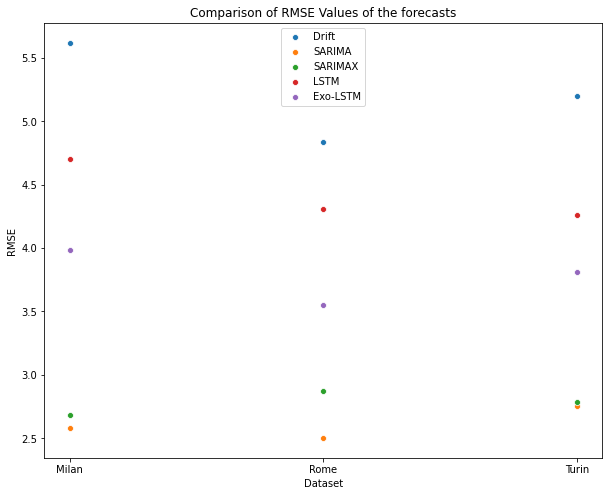

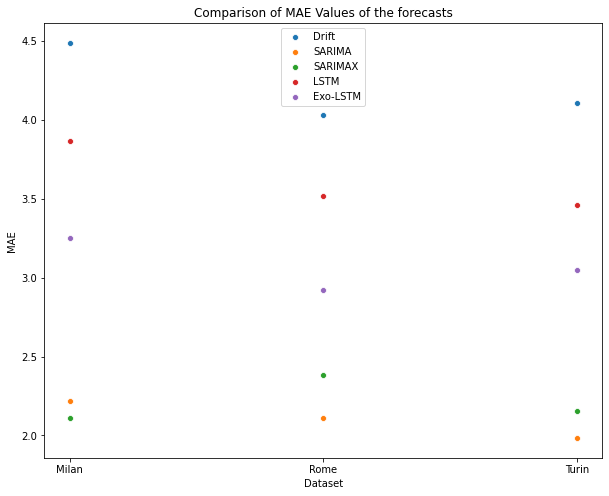

In [64]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax =sns.scatterplot(x=mean_results.index, y="SARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="SARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="LSTM RMSE", data=mean_results, label="LSTM")
ax = sns.scatterplot(x=mean_results.index, y="Exo-LSTM RMSE", data=mean_results, label="Exo-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="SARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="SARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="LSTM MAE", data=mean_results, label="LSTM")
aax = sns.scatterplot(x=mean_results.index, y="Exo-LSTM MAE", data=mean_results, label="Exo-LSTM")
aax.set(ylabel="MAE")
plt.show()